In [3]:
import os, ast
import numpy as np 
import pandas as pd 

from matplotlib import pyplot as plt 
import matplotlib.patches as patches
import seaborn as sns
from keras import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K
from tensorflow.keras.utils import img_to_array,array_to_img, load_img
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageChops

from sklearn.neighbors import KernelDensity
import random

AlreadyExistsError: Another metric with the same name already exists.

In [5]:
DIR_INPUT = 'C:/Users/sai/Downloads/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [6]:
#Read Data
#Read the train.csv data:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
sample_sub_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
train_df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [7]:
print(f'Shape of training data: {train_df.shape}')
print(f'Shape of given test data: {sample_sub_df.shape}')


Shape of training data: (147793, 5)
Shape of given test data: (10, 2)


In [8]:
print(f'# of unique images: {train_df["image_id"].nunique()}')


# of unique images: 3373


In [9]:
#size of the images
print(f'Unique heights and widths: {train_df["width"].unique()}, {train_df["height"].unique()}')

Unique heights and widths: [1024], [1024]


In [10]:
print(f'Total number of images: {len(os.listdir((DIR_TRAIN)))}')


Total number of images: 3369


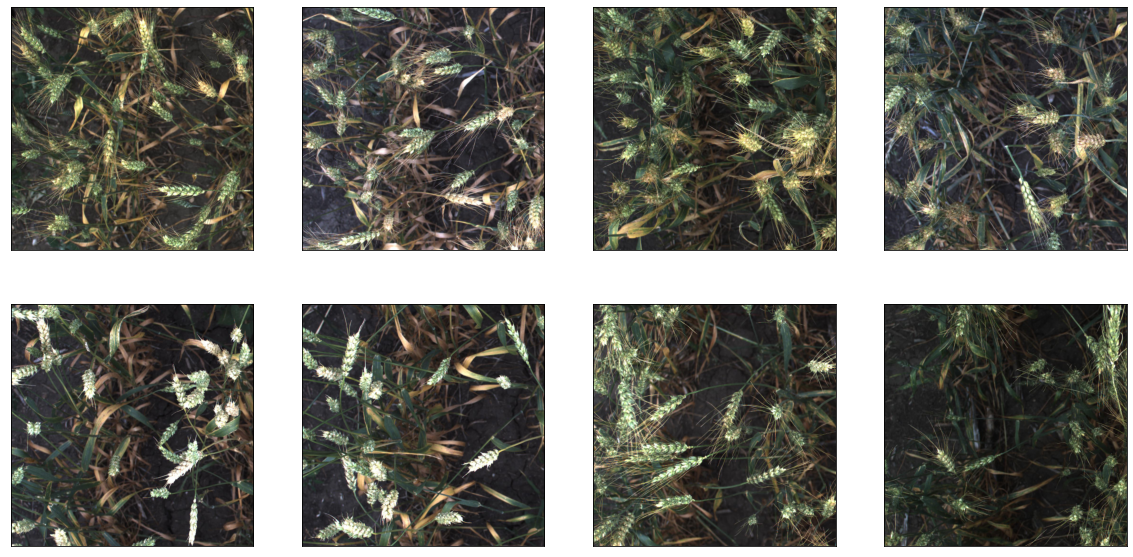

In [11]:
# Visualize few samples of current training dataset
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
count=0
for row in ax:
    for col in row:
        img = plt.imread(f'{os.path.join(DIR_TRAIN, train_df["image_id"].unique()[count])}.jpg')
        col.grid(True)
        col.set_xticks([])
        col.set_yticks([])
        col.imshow(img)
        count += 1
plt.show()

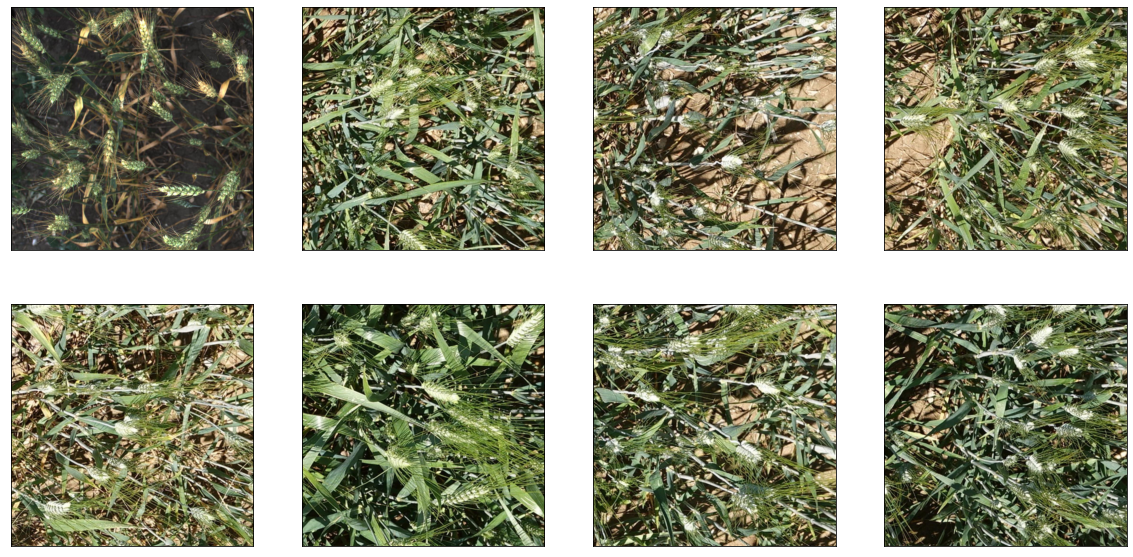

In [12]:
# Visualize few samples of current training dataset
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
count=0
for row in ax:
    for col in row:
        img = plt.imread(f'{os.path.join(DIR_INPUT, "train", train_df["image_id"].unique()[-count])}.jpg')
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        col.imshow(img)
        count += 1
plt.show()

In [13]:
train_df[['x_min','y_min', 'width', 'height']] = pd.DataFrame([ast.literal_eval(x) for x in train_df.bbox.tolist()], index= train_df.index)
train_df = train_df[['image_id', 'bbox', 'source', 'x_min', 'y_min', 'width', 'height']]
train_df

image_id                         bbox     source  x_min  y_min  \
0       b6ab77fd7   [834.0, 222.0, 56.0, 36.0]    usask_1  834.0  222.0   
1       b6ab77fd7  [226.0, 548.0, 130.0, 58.0]    usask_1  226.0  548.0   
2       b6ab77fd7  [377.0, 504.0, 74.0, 160.0]    usask_1  377.0  504.0   
3       b6ab77fd7  [834.0, 95.0, 109.0, 107.0]    usask_1  834.0   95.0   
4       b6ab77fd7  [26.0, 144.0, 124.0, 117.0]    usask_1   26.0  144.0   
...           ...                          ...        ...    ...    ...   
147788  5e0747034    [64.0, 619.0, 84.0, 95.0]  arvalis_2   64.0  619.0   
147789  5e0747034  [292.0, 549.0, 107.0, 82.0]  arvalis_2  292.0  549.0   
147790  5e0747034  [134.0, 228.0, 141.0, 71.0]  arvalis_2  134.0  228.0   
147791  5e0747034   [430.0, 13.0, 184.0, 79.0]  arvalis_2  430.0   13.0   
147792  5e0747034   [875.0, 740.0, 94.0, 61.0]  arvalis_2  875.0  740.0   

        width  height  
0        56.0    36.0  
1       130.0    58.0  
2        74.0   160.0  
3       109.0   107.0  
4       124.0   117.0  
...       ...     ...  
147788   84.0    95.0  
147789  107.0    82.0  
147790  141.0    71.0  
147791  184.0    79.0  
147792   94.0    61.0  

[147793 rows x 7 columns]

In [14]:
def get_bbox(image_id, df, col, color='white'):
    bboxes = df[df['image_id'] == image_id]
    
    for i in range(len(bboxes)):
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (bboxes['x_min'].iloc[i], bboxes['y_min'].iloc[i]),
            bboxes['width'].iloc[i], 
            bboxes['height'].iloc[i], 
            linewidth=2, 
            edgecolor=color, 
            facecolor='none')

        # Add the patch to the Axes
        col.add_patch(rect)

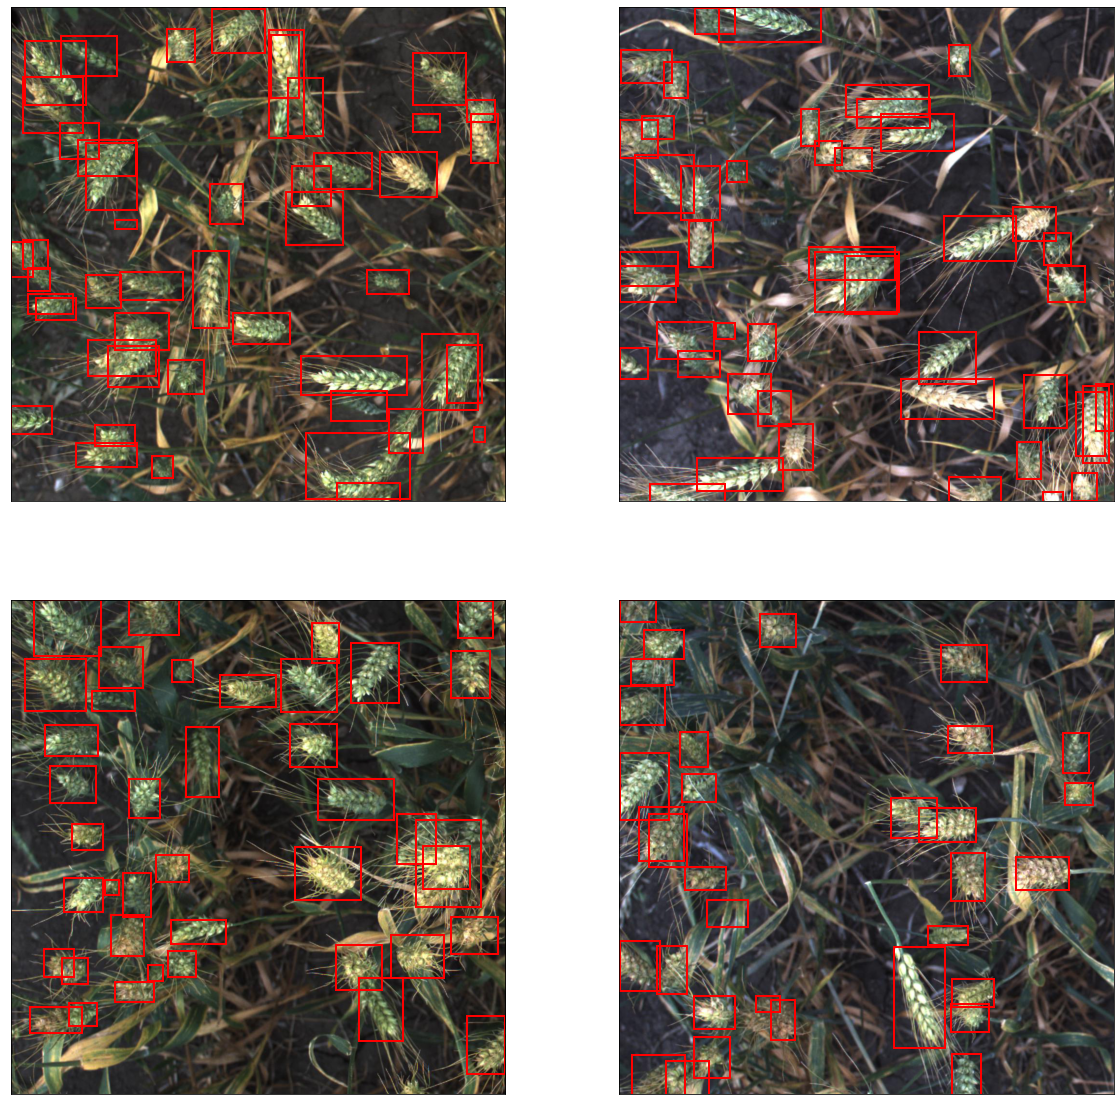

In [15]:
# Visualize few samples of current training dataset
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
count=0
for row in ax:
    for col in row:
        img_id = train_df["image_id"].unique()[count]
        img = plt.imread(f'{os.path.join(DIR_INPUT,"train", img_id)}.jpg')
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        get_bbox(img_id, train_df, col, color='red')
        col.imshow(img)
        count += 1
plt.show()

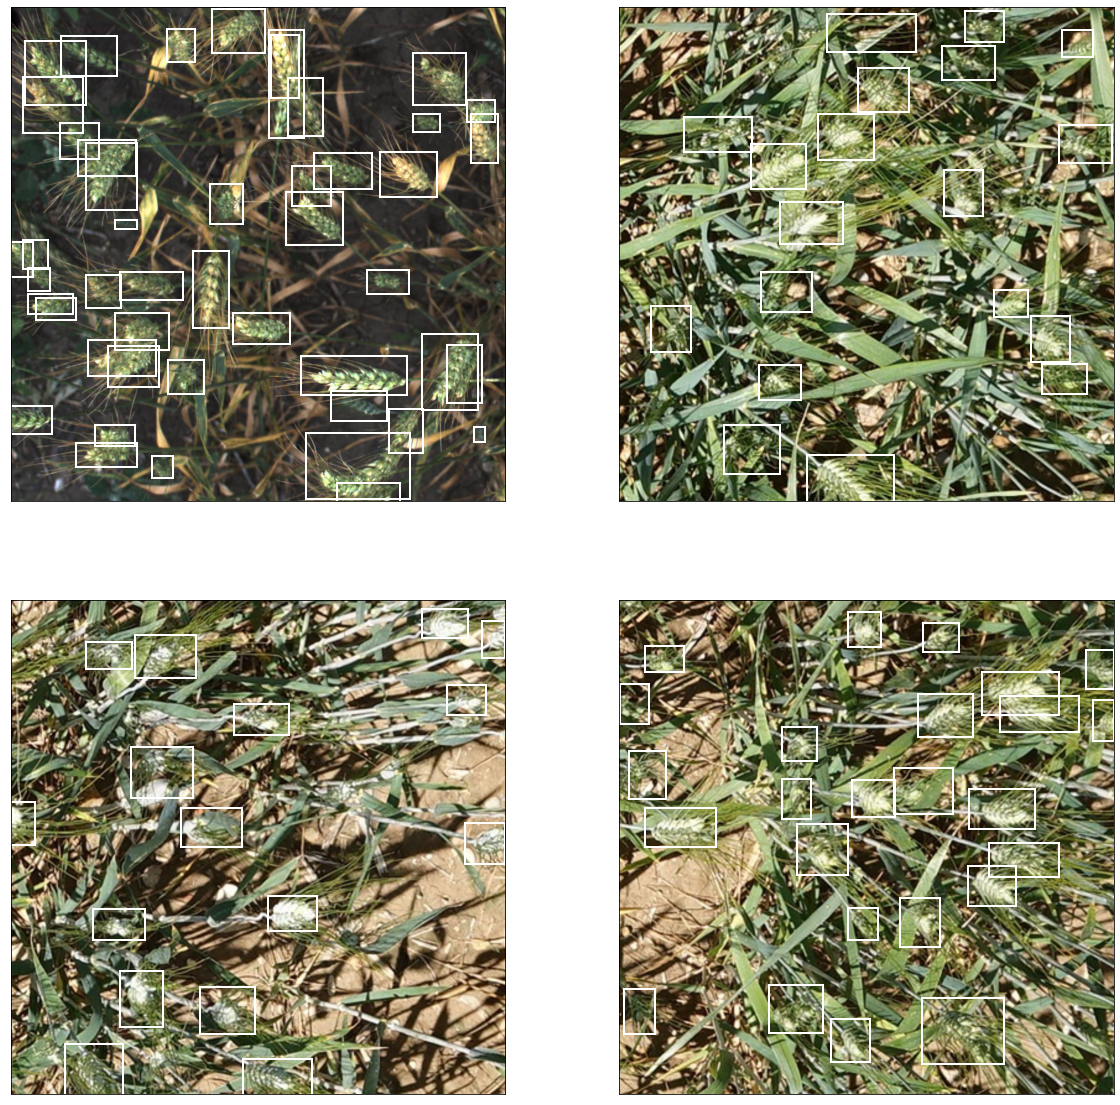

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
count=0
for row in ax:
    for col in row:
        img_id = train_df["image_id"].unique()[-count]
        img = plt.imread(f'{os.path.join(DIR_INPUT, "train", img_id)}.jpg')
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        get_bbox(img_id, train_df, col)
        col.imshow(img)
        count += 1
plt.show()

In [17]:
#exploring image in traing dataset without wheat head

all_images = os.listdir(os.path.join(DIR_INPUT, 'train'))
all_images = set([x[:-4] for x in all_images])

images_with_bbox = set(list(train_df['image_id']))

images_without_bbox = list(all_images - images_with_bbox)

In [21]:
print(images_without_bbox)
print(images_with_bbox)

[]
{'5f3d068f1', '49d76c63d', 'bd5cb3bc5', 'fab41168b', '8f0434556', 'd89cae86c', '43ac88073', 'd781eb0c1', 'bce2fdc4d', '69d37b0ba', '3aea733b5', 'fa0f32e52', 'e277cec54', '3a1f54e49', 'b2672900e', '9bccf7e53', '6f119c82d', '2d3e3f783', '2c534b9b6', '787d3091c', '866a328af', '9d9b579c6', '3dd44c524', 'bc226ebfd', '0bbb17b82', '34f2e3b92', '88dc94b76', '3843b28ec', '9302b9512', 'b6324ea82', '3ab9d0640', '1d7d9fda3', 'a18ff674f', 'bd20bc5c9', '8417e5762', '331c69189', '7826a88b5', '96b872ec8', '44b73b40d', 'ed1270725', '5d73dfef2', 'df0be3f16', 'c1577d6ff', '81020ba1b', '379ef727d', '5baa23af0', 'df74fc663', '86a279fe3', 'dafa14917', 'aeff69b31', 'e11b95f4e', 'b5487f037', '8bd3806b7', 'ec8640868', 'e321272b3', '0f4911203', 'b5e726c10', '50ee1a4fc', '877827fb3', 'd8f09768d', 'd1931b6bd', '340ac8d52', '43f9b9fc5', '4eb442168', '8fb3138d9', 'e5c9056ab', 'cabe03050', 'af1507e03', 'e5e1f2c65', '8a8df1c28', '0ff60b2bc', '94edec090', '5a5631a48', 'caa7d043e', '6a739d41b', '7cb9748c4', '443cc36